In [106]:
from random import random, seed
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

from icecream import ic

In [107]:
UNIVERSE_SIZE = 10000
NUM_SETS = 1000
DENSITY = 0.1

rng = np.random.Generator(
    np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)])
)

In [108]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = pow(SETS.sum(axis=1), 1.1)

In [109]:
valid = lambda solution: np.all(np.logical_or.reduce(SETS[solution]))
cost = lambda solution: COSTS[solution].sum()

ic| tabu: []


[]

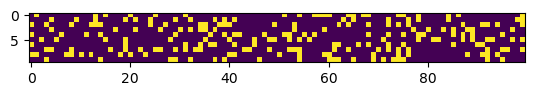

In [115]:
# Pre-processing

tabu = []
for i, cur_set in enumerate(SETS):
    if cur_set.sum() == 0:
        # empty set
        tabu.append(i)
plt.imshow(SETS)
ic(tabu)

In [111]:
from numpy import ceil, floor, ndarray


def plot(solution):
    plt.figure(figsize=(10, 10))
    plt.imshow(SETS[solution])
    plt.show()


def acceptable(geneset):
    try:
        return not any([geneset[t] for t in tabu]) and valid(geneset)
    except TypeError:
        return False


def mutate(
    genesets,
    min_mutations_percent: float = 0.1,
    max_mutations_percent: float = 0.1,
):
    """Tweaks the solution by adding/removing a random set"""
    new_genesets = genesets.copy()
    for new_geneset in new_genesets:
        mutating_genes = None
        while (
            mutating_genes is None
            or any(gene in tabu for gene in mutating_genes)
            or not valid(new_geneset)
        ):
            mutating_genes = rng.integers(
                0,
                NUM_SETS,
                rng.integers(
                    ceil(UNIVERSE_SIZE * min_mutations_percent),
                    floor(UNIVERSE_SIZE * max_mutations_percent),
                    endpoint=True,
                ),
            )
            new_geneset[mutating_genes] = ~new_geneset[mutating_genes]

    return new_genesets


def cross(genesets):
    new_genesets = np.empty_like(genesets)
    for i in range(genesets.shape[0]):
        new_geneset = None
        while not valid(new_geneset):
            mask = rng.random(NUM_SETS) < (rng.uniform(0.4, 0.6))
            new_geneset1 = np.logical_and(
                genesets[rng.integers(0, genesets.shape[0])], mask
            )
            new_geneset2 = np.logical_and(
                genesets[rng.integers(0, genesets.shape[0])], np.logical_not(mask)
            )
            new_geneset = np.logical_or(new_geneset1, new_geneset2)

        new_genesets[i] = new_geneset

    return new_genesets


def select(genesets: list, n: int = 1):
    costs: ndarray = np.array([cost(g) for g in genesets])
    sort_idx = np.argsort(costs)
    new_genesets = np.empty((n, NUM_SETS), dtype=bool)
    genesets_to_keep = rng.integers(1, n//4) if n > 8 else 1
    new_genesets[:genesets_to_keep] = genesets[
        sort_idx[:genesets_to_keep]
    ]  # Left some of the best ones unchanged, at most half
    indexes: list[int] = []
    probabilities: ndarray = costs - costs.min()
    probabilities = 1 / (1 + probabilities)
    probabilities /= probabilities.sum()
    for _ in range(
        n - genesets_to_keep
    ):  # probability to keep is proportional to the cost for the rest
        idx = rng.choice(range(costs.shape[0]), p=probabilities)
        indexes.append(idx)
    new_genesets[genesets_to_keep:] = genesets[indexes]

    new_costs = np.concatenate((costs[sort_idx[:genesets_to_keep]], costs[indexes]))
    return new_genesets, new_costs

In [112]:
# Const
ROUNDS = 3
MUTATION_PERCENT = (0.01, 0.05)

POPULATION_SIZE = int(sqrt(UNIVERSE_SIZE)/2) or 1
print(f"{POPULATION_SIZE = }")
print(f"Mutating genes: {UNIVERSE_SIZE * MUTATION_PERCENT[0]:.0f} to {UNIVERSE_SIZE * MUTATION_PERCENT[1]:.0f}")

POPULATION_SIZE = 5
Mutating genes: 1 to 5


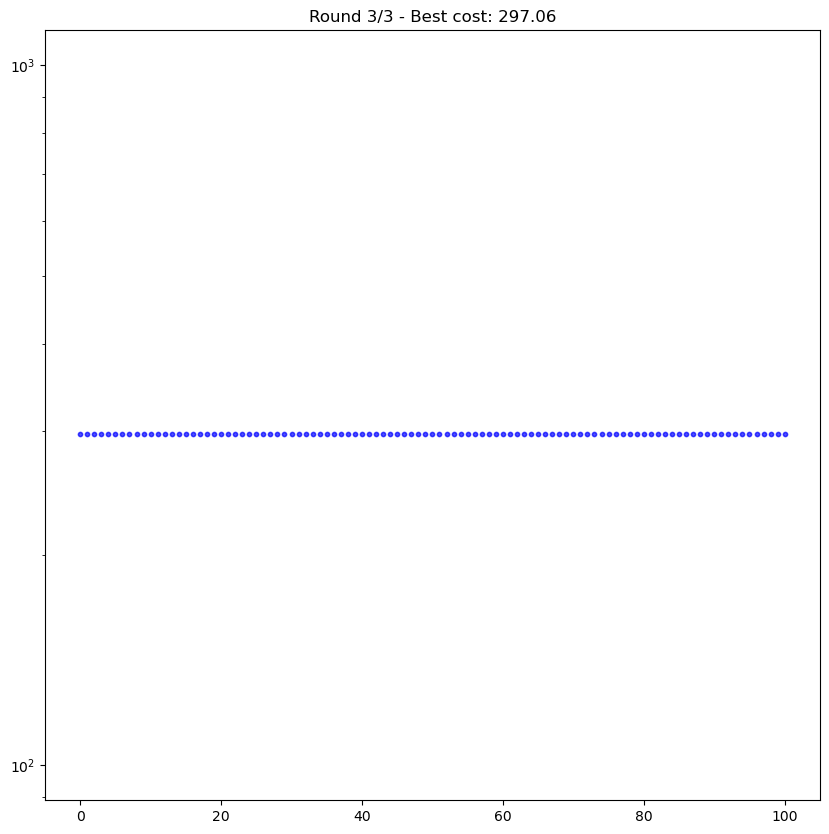

In [113]:
from IPython.display import display, clear_output
import time

fig1 = plt.figure(figsize=(10, 10))
ax1 = fig1.add_subplot(111)
#ax1.scatter([])

best_geneset_overall = None
best_cost_overall = float("inf")
best_round = 0
best_round_iterations = 0
total_iterations = 0

start = time.time()
for round in range(1, ROUNDS + 1):
    # Init
    genesets = np.empty((POPULATION_SIZE, NUM_SETS), dtype=bool)
    for i in range(POPULATION_SIZE):
        geneset = None
        while not valid(geneset):
            geneset = rng.random(NUM_SETS) < 0.5
        genesets[i] = geneset
    costs = np.array([cost(g) for g in genesets])
    best_cost = min(costs)
    last_best_cost = best_cost
    iters = 0
    stale_iterations = 0
    history = [costs]
    while True:
        iters += 1
        stale_iterations += 1
        mutated_genesets = mutate(genesets, min_mutations_percent=MUTATION_PERCENT[0], max_mutations_percent=MUTATION_PERCENT[1])
        population = np.concatenate([genesets, cross(mutated_genesets)], axis=0)
        genesets, costs = select(population, n=POPULATION_SIZE)
        best_cost = min(costs)

        if best_cost < last_best_cost:
            stale_iterations = 0
            last_best_cost = best_cost

        history.append(costs)
        if iters % 10 == 0:
            ax1.cla()
            ax1.set_title(f"Round {round}/{ROUNDS} - Best cost: {last_best_cost:.2f}")
            # Scatter plot - history is a list of arrays
            # I want a point for each element in the array
            # I want the x-axis to be the index of the array
            # I want the y-axis to be the value of the array
            for i, h in enumerate(history):
                ax1.scatter([i]*len(h), h, color='blue', alpha=1/POPULATION_SIZE, marker='.')
                ax1.set_yscale('log')
            display(fig1)
            clear_output(wait=True)
            plt.pause(0.1)

        if best_cost <= UNIVERSE_SIZE:
            break
        if iters > UNIVERSE_SIZE and stale_iterations/iters > 0.3:
            break
    total_iterations += iters

    if last_best_cost < best_cost_overall:
        best_cost_overall = last_best_cost
        best_geneset_overall = genesets[0]
        best_round = round
        best_round_iterations = iters
    if best_cost <= UNIVERSE_SIZE:
        print("Found optimal solution")
        break
elapsed = time.time() - start

In [114]:
minutes = int(elapsed // 60)
seconds = elapsed % 60
print(f"Elapsed time: {minutes}m {seconds:.2f}s")
print(f"Best cost: {best_cost_overall}")
print(f"Total number of iterations: {total_iterations}")
print(f"Best round: {best_round}/{ROUNDS}")
print(f"Iterations in round {best_round}: {best_round_iterations}")

print(f"Selected sets: {list(np.nonzero(best_geneset_overall))}")
#plt.imshow(SETS[best_geneset_overall])

if not valid(best_geneset_overall):
    print("Something terrible happened!")

Elapsed time: 0m 29.66s
Best cost: 297.055688135321
Total number of iterations: 303
Best round: 1/3
Iterations in round 1: 101
Selected sets: [array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]
